In [1]:
#default_exp tuning

# Tuning

<br>

### Imports

In [2]:
#exports
import json
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from batopt import clean, discharge, charge, utils

import os
from ipypb import track

In [3]:
import FEAutils as hlp
import matplotlib.pyplot as plt

from IPython.display import JSON

<br>

### User Inputs

In [4]:
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'

<br>

### Preparing Data

First we'll load in the target and feature data for both the charging and discharging models

In [5]:
charge_x, charge_y = charge.prepare_training_input_data(intermediate_data_dir)
discharge_x, discharge_y = discharge.prepare_training_input_data(intermediate_data_dir)

charge_x.head()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,pv_7d_lag,solar_location2,solar_location3,solar_location5,solar_location6,sin_hour,cos_hour,sin_doy,cos_doy
2017-11-10 05:00:00+00:00,12.190,12.07,11.880,11.29,13.37,13.43,0.00,0.00,0.00,0.000,0.00,0.965926,2.588190e-01,-0.769415,0.638749
2017-11-10 05:30:00+00:00,12.145,12.13,11.745,11.20,13.44,13.52,0.00,0.00,0.00,0.000,0.00,0.991445,1.305262e-01,-0.769415,0.638749
2017-11-10 06:00:00+00:00,12.100,12.19,11.610,11.11,13.51,13.61,0.00,0.00,0.00,0.000,0.00,1.000000,6.123234e-17,-0.769415,0.638749
2017-11-10 06:30:00+00:00,11.985,12.05,11.315,10.85,13.52,13.62,0.00,0.55,0.52,0.575,0.66,0.991445,-1.305262e-01,-0.769415,0.638749
2017-11-10 07:00:00+00:00,11.870,11.91,11.020,10.59,13.53,13.63,0.02,1.10,1.04,1.150,1.32,0.965926,-2.588190e-01,-0.769415,0.638749


In [6]:
s_demand = clean.load_training_dataset(intermediate_data_dir, 'demand')['demand_MW']

s_demand.head()

datetime
2017-11-03 00:00:00+00:00    2.19
2017-11-03 00:30:00+00:00    2.14
2017-11-03 01:00:00+00:00    2.01
2017-11-03 01:30:00+00:00    1.87
2017-11-03 02:00:00+00:00    1.86
Freq: 30T, Name: demand_MW, dtype: float64

In [7]:
s_pv = clean.load_training_dataset(intermediate_data_dir, 'pv')['pv_power_mw']

s_pv.head()

datetime
2017-11-03 00:00:00+00:00    0.0
2017-11-03 00:30:00+00:00    0.0
2017-11-03 01:00:00+00:00    0.0
2017-11-03 01:30:00+00:00    0.0
2017-11-03 02:00:00+00:00    0.0
Freq: 30T, Name: pv_power_mw, dtype: float64

In [8]:
def get_train_test(arr, start_of_test_period): 
    train_arr = arr[:pd.to_datetime(start_of_test_period, utc=True)]
    test_arr = arr[pd.to_datetime(start_of_test_period, utc=True):]
    
    return train_arr, test_arr

start_of_test_period = '2018-09-15'

charge_x_train, charge_x_test = get_train_test(charge_x, start_of_test_period)
charge_y_train, charge_y_test = get_train_test(charge_y, start_of_test_period)
discharge_x_train, discharge_x_test = get_train_test(discharge_x, start_of_test_period)
discharge_y_train, discharge_y_test = get_train_test(discharge_y, start_of_test_period)

<br>

### Evaluation Metrics

We want to evaluate each of our models based on their contribution to the final scoring value, to do this we'll first create some predictions for our discharge model.

<AxesSubplot:>

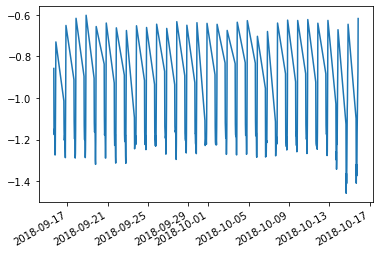

In [9]:
discharge_rf = RandomForestRegressor()

discharge_rf.fit(discharge_x_train, discharge_y_train)
discharge_y_pred = pd.Series(discharge_rf.predict(discharge_x_test), index=discharge_x_test.index)

discharge_y_pred.plot()

<br>

We'll then create a time-series of the percentage peak reduction for each day

In [10]:
#exports
def calculate_pct_peak_reduction_s(discharge_y_pred, s_demand):
    s_demand_test = s_demand.loc[discharge_y_pred.index]

    s_old_peaks = s_demand_test.groupby(s_demand_test.index.date).max()
    s_new_peaks = (s_demand_test+discharge_y_pred).groupby(s_demand_test.index.date).max()

    s_pct_peak_reduction = 100*(s_old_peaks - s_new_peaks)/s_new_peaks
    s_pct_peak_reduction.index = pd.to_datetime(s_pct_peak_reduction.index)

    return s_pct_peak_reduction

The average peak reduction was 45.48%


<AxesSubplot:>

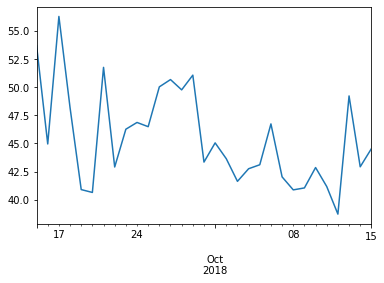

In [11]:
s_pct_peak_reduction = calculate_pct_peak_reduction_s(discharge_y_pred, s_demand)

print(f'The average peak reduction was {s_pct_peak_reduction.mean():.2f}%')

s_pct_peak_reduction.plot()

<br>

We'll then repeat this with the charging model

<AxesSubplot:>

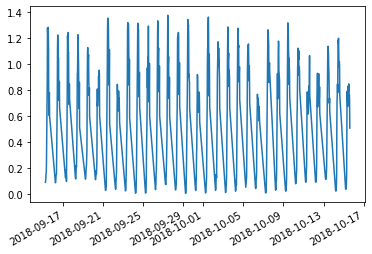

In [12]:
charge_rf = RandomForestRegressor()

charge_rf.fit(charge_x_train, charge_y_train)
charge_y_pred = pd.Series(charge_rf.predict(charge_x_test), index=charge_x_test.index)

charge_y_pred.plot()

<br>

For which we'll calculate the emissions factor series

In [13]:
#exports
def calculate_emissions_factor_s(charge_y_pred, s_pv, solar_factor=3, grid_factor=1):
    s_solar_charge_pct = (charge_y_pred - s_pv.loc[charge_y_pred.index]).clip(0).groupby(charge_y_pred.index.date).sum()/charge_y_pred.groupby(charge_y_pred.index.date).sum()
    s_grid_charge_pct = 1 - s_solar_charge_pct

    s_emissions_factor = solar_factor*s_solar_charge_pct + grid_factor*s_grid_charge_pct
    s_emissions_factor.index = pd.to_datetime(s_emissions_factor.index)

    return s_emissions_factor

<AxesSubplot:>

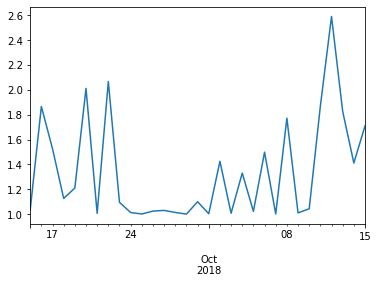

In [14]:
s_emissions_factor = calculate_emissions_factor_s(charge_y_pred, s_pv)

s_emissions_factor.plot()

<br>

We can then combine these two steps to determine our final score for each day

In [15]:
#exportd
def calculate_score_s(discharge_y_pred, charge_y_pred, s_demand, s_pv, solar_factor=3, grid_factor=1):
    s_pct_peak_reduction = calculate_pct_peak_reduction_s(discharge_y_pred, s_demand)
    s_emissions_factor = calculate_emissions_factor_s(charge_y_pred, s_pv, solar_factor=solar_factor, grid_factor=grid_factor)
    
    s_score = s_pct_peak_reduction*s_emissions_factor
    
    return s_score

The average score was: 60.47


<AxesSubplot:>

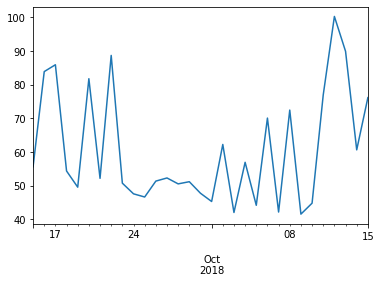

In [16]:
s_score = calculate_score_s(discharge_y_pred, charge_y_pred, s_demand, s_pv)

print(f'The average score was: {s_score.mean():.2f}')

s_score.plot()

<br>

For the charging we can also look at how much was sourced from PV relative to the potential maximum (capped at 6 MWh per day).

<AxesSubplot:>

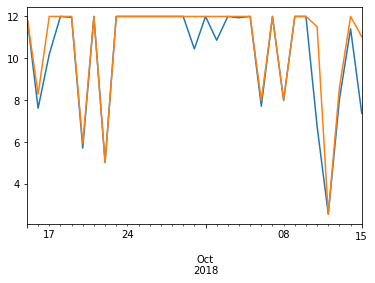

In [17]:
solar_charge = np.minimum(charge_y_pred, s_pv.loc[charge_y_pred.index])
day_solar_charge = solar_charge.groupby(solar_charge.index.date).sum().clip(0,12)
day_solar_charge.index = pd.to_datetime(day_solar_charge.index)

solar_potential = np.clip(s_pv.loc[charge_y_pred.index], 0, 2.5)
day_solar_potential = solar_potential.groupby(solar_potential.index.date).sum().clip(0,12)
day_solar_potential.index = pd.to_datetime(day_solar_potential.index)

day_solar_charge.plot()
day_solar_potential.plot()

Text(0, 0.5, '% exploited')

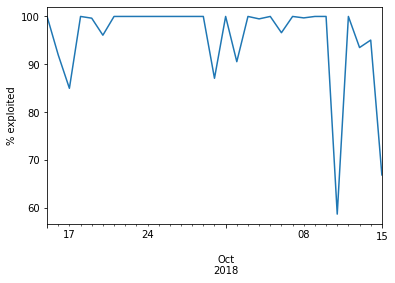

In [18]:
pct_exploit = 100 * day_solar_charge/day_solar_potential
pct_exploit.plot()
plt.ylabel('% exploited')

<br>

### Discharge Model Tuning

We'll begin by carrying out some feature selection

In [19]:
#exports
def feature_selection(x_train, y_train, groups=None, model=RandomForestRegressor(), min_num_features=1, max_num_features=None, **sfs_kwargs):
    if max_num_features is None:
        max_num_features = 1 + x_train.shape[1]
        
    result_features = dict()
    result_scores = dict()

    for num_features in track(range(min_num_features, max_num_features)):
        sfs = SFS(
            model,
            k_features=num_features, 
            **sfs_kwargs
        )

        sfs.fit(x_train, y_train, groups=groups)

        result_features[num_features] = sfs.k_feature_names_
        result_scores[num_features] = sfs.k_score_
        
    return result_features, result_scores

In [20]:
peak_reduction_scorer = discharge.construct_peak_reduction_calculator(s_demand=s_demand.loc[discharge_x_train.index], scorer=True)
week_groups = discharge_x_train.index.year + discharge_x_train.index.isocalendar().week/52

rerun_feature_selection = False
feature_selection_filename = f'feature_selection.json'

if (rerun_feature_selection == True) or (feature_selection_filename not in os.listdir(cache_data_dir)):
    result_features, result_scores = feature_selection(discharge_x_train, discharge_y_train, groups=week_groups, n_jobs=-1)
    
    with open(f'{cache_data_dir}/{feature_selection_filename}', 'w') as fp:
        json.dump(dict(zip(['features', 'scores'], [result_features, result_scores])), fp)
        
else:
    with open(f'{cache_data_dir}/{feature_selection_filename}', 'r') as fp:
        results = json.load(fp)
        
    result_features, result_scores = results['features'], results['scores']

 [████████████████████████████████████████████████████████████] 15/15 [28:45<04:22, 115.00s/it]

<br>

We can visualise how the model accuracy changes with the number of features included

<AxesSubplot:>

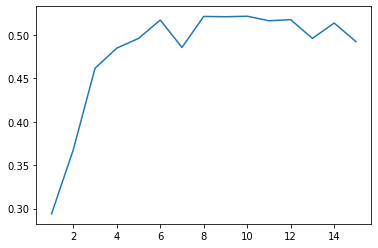

In [21]:
pd.Series(result_scores).plot()

<br>

We'll also calculate the relative importance of each feature by counting how many times they were included in the optimal feature subset

In [22]:
flatten_iterables = lambda iterable: [item for sublist in list(iterable) for item in sublist]

s_feature_importance = pd.Series(flatten_iterables(result_features.values())).value_counts().divide(len(result_features))

s_feature_importance

hour                         1.000000
doy                          0.933333
temp_location4               0.866667
SP_demand_7d_lag             0.666667
weekend                      0.666667
evening_demand_max_7d_lag    0.600000
evening_demand_avg_7d_lag    0.600000
temp_location3               0.533333
temp_location2               0.466667
daily_avg_temp               0.466667
spatial_avg_temp             0.400000
temp_location1               0.333333
temp_location6               0.200000
dow                          0.133333
temp_location5               0.133333
dtype: float64

In [23]:
# hour                         1.000000
# doy                          0.933333
# temp_location4               0.866667
# weekend                      0.733333
# evening_demand_max_7d_lag    0.600000
# daily_avg_temp               0.600000
# SP_demand_7d_lag             0.600000
# evening_demand_avg_7d_lag    0.533333
# temp_location1               0.533333
# temp_location3               0.466667
# temp_location2               0.333333
# spatial_avg_temp             0.333333
# temp_location5               0.200000
# dow                          0.133333
# temp_location6               0.133333

## Much slower backwards calculation
# evening_demand_avg_7d_lag    1.000000
# SP_demand_7d_lag             0.933333
# temp_location4               0.866667
# hour                         0.800000
# evening_demand_max_7d_lag    0.733333
# temp_location6               0.666667
# weekend                      0.400000
# daily_avg_temp               0.400000
# temp_location5               0.400000
# temp_location2               0.400000
# temp_location3               0.400000
# temp_location1               0.333333
# spatial_avg_temp             0.333333
# dow                          0.266667
# doy                          0.066667

<br>

We'll now do some hyper-parameter tuning using the `skopt` library

In [24]:
# Look at plotting callback - https://github.com/scikit-optimize/scikit-optimize/issues/576#issuecomment-507395129

features = s_feature_importance.index[:11]
evening_datetimes = discharge.extract_evening_datetimes(discharge_x_train)
week_groups = discharge_x_train.index.year + discharge_x_train.index.isocalendar().week/52
peak_reduction_scorer = discharge.construct_peak_reduction_calculator(s_demand=s_demand, scorer=True)

pipeline = Pipeline([
    # Add in oversampling of more recent/similar dates
    ('pandas_RF', utils.PandasRandomForestRegressor())
])

search_spaces = {
        'pandas_RF__min_samples_leaf': Integer(1, 20, 'uniform'),
        'pandas_RF__criterion': Categorical(['mse', 'mae']),
        'pandas_RF__n_estimators': Integer(50, 250, 'uniform'),
        'pandas_RF__max_features': Categorical(['auto', 'sqrt']),
        'pandas_RF__max_depth': Integer(10, 50, 'uniform'),
        'pandas_RF__min_samples_split': Integer(2, 10, 'uniform'),
        'pandas_RF__min_samples_leaf': Integer(1, 4, 'uniform'),
        'pandas_RF__bootstrap': Categorical([True, False])
}

opt = utils.BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=15,
    verbose=1,
    cv=8, # 8 works well for me as that's how many concurrent workers I can use
    scoring=peak_reduction_scorer,
    n_jobs=-1
)

fit_BayesSearchCV = True

if fit_BayesSearchCV == True:
    opt.fit(discharge_x_train[features], discharge_y_train, groups=evening_datetimes.date)

    print(f'Cross-validation score: {opt.best_score_:.2f}')
    print(f'Hold-out score: {opt.score(discharge_x_test[features], discharge_y_test):.2f}')
    print(f'\nBest params: \n{opt.best_params_}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   23.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  4.0min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   43.7s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   47.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   41.7s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   46.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   33.1s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   36.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.6s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.2s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.2min finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   20.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   22.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   20.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   21.2s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   46.7s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   49.0s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   19.8s remaining:   59.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   21.4s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.9s finished


Cross-validation score: 92.78
Hold-out score: 81.17

Best params: 
OrderedDict([('pandas_RF__bootstrap', True), ('pandas_RF__criterion', 'mae'), ('pandas_RF__max_depth', 14), ('pandas_RF__max_features', 'sqrt'), ('pandas_RF__min_samples_leaf', 2), ('pandas_RF__min_samples_split', 6), ('pandas_RF__n_estimators', 214)])


In [25]:
# Cross-validation score: 91.20
# Hold-out score: 80.95

# Cross-validation score: 91.94
# Hold-out score: 80.49

# ['hour', 'doy', 'temp_location4', 'weekend', 'evening_demand_max_7d_lag', 'daily_avg_temp', 'SP_demand_7d_lag', 'evening_demand_avg_7d_lag', 'temp_location1']
# 2 iters
# Cross-validation score: 92.75 
# Hold-out score: 81.64

# 
# 15 iters
# Cross-validation score:  
# Hold-out score: 

In [26]:
# want to be saving model runs
# could include as part of a callback?

<br>

Finally we'll export the relevant code to our `batopt` module

In [27]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-retrieval.ipynb.
Converted 02-cleaning.ipynb.
Converted 03-charging.ipynb.
Converted 04-discharging.ipynb.
Converted 05-constraints.ipynb.
Converted 06-tuning.ipynb.
Converted 07-charging-nn.ipynb.
Converted 08-pv-forecast.ipynb.
Converted 09-pipeline.ipynb.
